<a href="https://colab.research.google.com/github/Computerglassformedandsurg/SAM_based_ASTM_Grain_Size_Analysis/blob/main/373_SAM_based_ASTM_Grain_Size_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmenteverygrain rtree # rtree is for spatial indexing

Caution: Sometime the image can be with one channel


## Mount the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Unet model - Already downloaded (mount the drive)

In [ ]:
# import os

# # 1. Create the full directory path (this handles the space correctly)
# target_dir = "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/"
# os.makedirs(target_dir, exist_ok=True)

# # 2. Move and rename the incorrectly named file to the right spot
# # In your log, it was saved as '/content/drive/MyDrive/Segmentation'
# !mv "/content/drive/MyDrive/Segmentation" "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/seg_model.keras"

# print("Done! Checking the file location...")
# !ls -lh "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/"

Done! Checking the file location...
total 25M
-rw------- 1 root root 25M Dec 18 03:05 seg_model.keras


## Download SAM models - Already downloaded (mount the drive)


In [3]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/sam_vit_b_01ec64.pth"


## Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image
from scipy import ndimage
from skimage import measure
import os
from pathlib import Path

import segmenteverygrain as seg
from keras.utils import load_img
from segment_anything import sam_model_registry, SamPredictor
from tqdm import tqdm

Model_Paths = {
    'unet': "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/seg_model.keras",
    'sam': "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/sam_vit_b_01ec64.pth"

}

In [5]:
Img_path = "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/Microstructure.jpg"
output_path = "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/Results"

Scale_um_per_pixel = 0.25 # adjust based on the microscope settings
Main_grain_area = 100 #minimum grain area in pixels

## Image Loading and preprocessing

### Function to convert from RGB to Grayscale

In [6]:
# function to convert RGB to grayscale
def convert_rgb_to_gray(image):
  """
  Simply converting rgb to gray
  converts 3 dimensional image using the formula
  if the image is gray or one dimension then it returns the first channel itself

  Standard RGB (3 channels): It applies the math and flattens the 3 layers into 1.

  Single-channel images (Shape (H, W, 1)): It just "squeezes" the extra dimension to give you a 2D array.

  Already Grayscale (2D array): It returns the image exactly as it is.
  """
  if len(image.shape) == 2: # if the image is 2D, then return it
    return image

  if len(image.shape) == 3: # if it is 3D (H, W, C)
    # Check if it has 3 channels
    if image.shape[2] == 3:
      gray = 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]
      return gray.astype(np.uint8)
    else:
    # If it's (H, W, 1), just return the 2D slice
      return image[:,:,0]
  return image

In [8]:
# Load the microstructure image
original_image = np.array(load_img(Img_path))

# Convert to grayscale for analysis
if len(original_image.shape) == 3:
  gray_image = convert_rgb_to_gray(original_image)
else:
  gray_image = original_image


## Display the loaded image

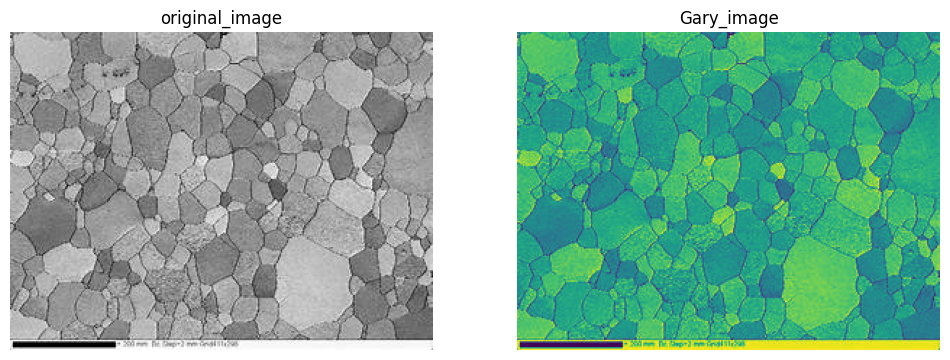

In [9]:
plt.figure(figsize = (12,5))
if len(original_image.shape) == 3:
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("original_image")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(gray_image)
  plt.title("Gary_image")
  plt.axis('off')

else:
  plt.imshow(original_image, cmap = 'gray')
  plt.title("Original image")
  plt.axis('off')



## UNET Grain Detection

In [10]:
# Load the unet model
try:
  unet_model = seg.load_model(
      Model_Paths['unet'],
      custom_objects = {'weighted_crossentropy' : seg.weighted_crossentropy}
  )
  print("Unet model is loaded successfully")
except Exception as e:
  print(f"Error loading U-Net model: {e}")
  raise

Unet model is loaded successfully


## Unet Prediction

In [12]:
img_pred = seg.predict_image(original_image, unet_model, I=256)
print(f"U-net segmented image.shape: {img_pred.shape}")

segmenting image tiles...


100%|██████████| 2/2 [00:00<00:00, 11848.32it/s]


U-net segmented image.shape: (220, 292, 3)


## Extract Grain ingredients

In [14]:
#If two "potential" grain points are closer than this distance - 6.0, the code treats them as the same grain.
labels_unet, coords = seg.label_grains(original_image, img_pred, dbs_max_dist = 0.6)
No_of_labels = len(coords)
print(f"Found {No_of_labels} labels")

Found 311 labels


## Visualize the Unet results

(np.float64(-0.5), np.float64(291.5), np.float64(219.5), np.float64(-0.5))

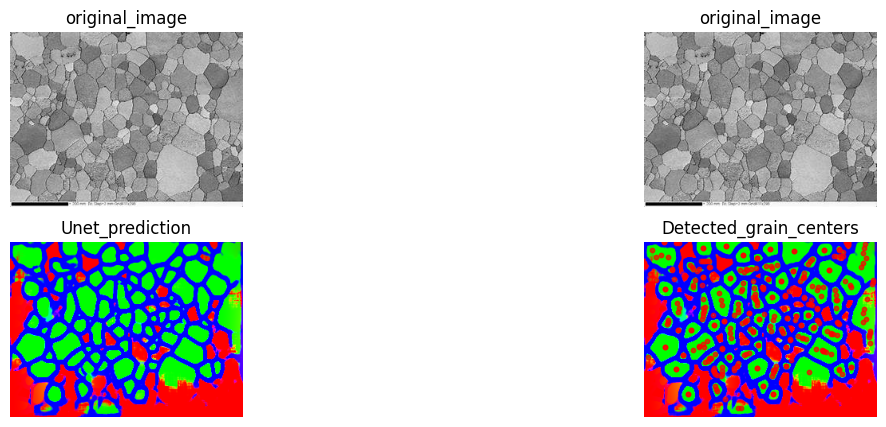

In [26]:
plt.figure(figsize=(15,5))

plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title("original_image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title("original_image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_pred, cmap='hot')
plt.title("Unet_prediction")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img_pred, cmap='gray')
if No_of_labels > 0:
  coords_array  = np.array(coords)
  plt.scatter(coords_array[:,0], coords_array[:,1], c='red',s=10, alpha=0.7)
plt.title("Detected_grain_centers")
plt.axis("off")

Ref - https://www.youtube.com/watch?v=KCGKLh05HRM